# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Homework 7: Generative Models - Variational Autoencoders and GANs [100 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- For this homework **you do NOT need to restart the kernel and run the whole notebook again before you submit**.
- **You should SAVE your models, and do not retrain on notebook reruns**.
- In this homework we import general keras library objects. Feel free to experiment and use different layers, optimizers, random initializers... whater you like using from the core libraries we import.
- Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

---

<div class="theme"> Overview </div> 

We are going to compare autoencoders (AEs), variational autoencoders (VAEs) and generative adversarial networks (GANs). The goal is to understand the particularities of each model and to learn how to build them. 

In addition to standard VAEs, we will also study conditional VAEs. Conditional VAEs incorporate input attributes on the latent representation of an input, providing some structure in the latent space. We will analyze how conditioal VAEs are capable of generating new photos according that depend on specified attributes. 

We are going to train our networks using [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is a large-scale face attributes dataset with more than 200K celebrity images and 40 different attribute annotations.

Run the following cell to load important libraries.

In [2]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt
plt.gray()

**Check availability of GPU**

Run this line to verify your instance is lists an available GPU.

In [3]:
from tf_keras_vis.utils import print_gpus

In [4]:
print_gpus()

1 Physical GPUs, 1 Logical GPU


In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

**Dowload CelebA Dataset**

Make sure to have `tensorflow_datasets` installed on version 2.1.0 before running following cell. You can install by running the following code on a **terminal** (not from Jupyter):

```pip install tensorflow_datasets==2.1.0```

Download CelebA if you have not downloaded it already. You can use the following line to download manually from a **terminal**:

```wget https://cs109b2020.s3.amazonaws.com/2.0.0.zip```

Uncompress it under ```~/tensorflow_datasets/celeb_a/2.0.0/```.


In [6]:
# Run this cell
# Assumes CelebA has been manually downloaded and is available in `~/tensorflow_datasets/celeb_a/2.0.0/`.

import tensorflow_datasets as tfds

train_celeb, val_celeb = tfds.load('celeb_a', split=['train', 'validation'], shuffle_files=False, download=False)

In [7]:
# Global variables to define training/loading models. 
# Modify as required. These are only suggested parameters.

train = True
epochs = 5  # number of epochs to train models
batch_size = 32
input_size = (64, 64, 3)  # images will be cropped and resized to `input_size`.

---

## <div class='exercise'><b>Question 1: Preprocess and visualize the data [20 pts]</b></div>

CelebA has 202,599 face images of various celebrities and training on the whole set requires large computational resources to fit your models. For this reason we recommend cropping the images and resizing them to reduce to computational costs. Feel free to adjust the images resolution depending on your computation capabilities. We recommend using `image_size = (64,64,3)`, but feel free to use a larger resolution, or smaller, up to `image_size = (32,32,3)`. 

We provide the function `tf_norm_crop_resize_image` to normalize image pixels between `[0,1]`, to crop the height and width of images to `150x150` pixels, and to [resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) images to the indicated size in the function call. Follow the intructions below to format your data for the different models you will need to train:

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

In [8]:
# DO NOT DELETE THIS CELL
# Use this function to normalize, crop and resize your images.
def tf_norm_crop_resize_image(image, resize_dim):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    and resizes to `resize_dim`, returning an image tensor."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

## Answers

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

In [9]:
# 1.1
# your code here
def get_im_tuple(element, resize_dim):
    image = element['image']
    image = tf_norm_crop_resize_image(image, resize_dim)
    return (image, image)

In [10]:
train_dataset = train_celeb.map(lambda element: get_im_tuple(element, (64,64)))
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_ds = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_celeb.map(lambda element: get_im_tuple(element, (64,64)))
val_dataset = val_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
val_ds = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

In [11]:
# 1.2
# your code here 
def get_im_attr_tuple(element, resize_dim):
    image = element['image']
    image = tf_norm_crop_resize_image(image, resize_dim)
    attributes = element['attributes']['Male'], element['attributes']['Smiling']
    attributes = tf.cast(attributes, tf.float32)
    return ((image, attributes), image)

In [12]:
train_cond_dataset = train_celeb.map(lambda element: get_im_attr_tuple(element, (64,64)))
train_cond_dataset = train_cond_dataset.shuffle(buffer_size=1024)
train_cond_dataset = train_cond_dataset.batch(batch_size, drop_remainder=True)
train_cond_ds = train_cond_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_cond_dataset = val_celeb.map(lambda element: get_im_attr_tuple(element, (64,64)))
val_cond_dataset = val_cond_dataset.shuffle(buffer_size=1024)
val_cond_dataset = val_cond_dataset.batch(batch_size, drop_remainder=True)
val_cond_ds = val_cond_dataset.prefetch(tf.data.experimental.AUTOTUNE)

**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

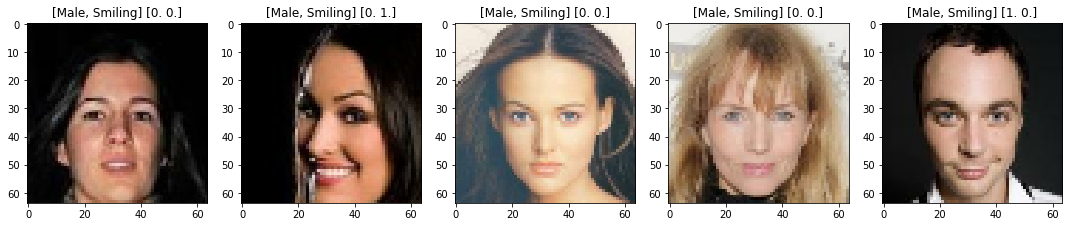

In [13]:
# 1.3
# your code here
fig, ax = plt.subplots(1, 5, figsize=(15,3))

for i, tuple_images_attr in enumerate(train_cond_ds.take(5)):
    n = np.random.randint(0, 32)
    image = tuple_images_attr[0][0][n]
    attributes = tuple_images_attr[0][1][n].numpy()
    idx2male = {0: 'Female', 1: 'Male'}
    idx2smile = {0: 'Not smiling', 1: 'Smiling'}
    ax[i].imshow(image)
    ax[i].set_title(f'{idx2smile[attributes[1]]} {idx2male[attributes[0]]}')

plt.tight_layout()

---

<div class='exercise'> <b> Question 2: Set-up an AutoEncoder [20 points] </b> </div>

**Define custom convolutional layers**

We provide below the skeleton of a custom keras layer that you need to complete to build the following models. You should read the Keras [guidelines](https://www.tensorflow.org/guide/keras/custom_layers_and_models) on how to build custom layers. You are required to fill the specific methods indicated below on each part.

You will then construct an autoencoder using both custom layers, and visualize the AE image reconstruction and latent spaces.

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

**We recommend [saving](https://www.tensorflow.org/tutorials/keras/save_and_load) the trained model**.

**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

## Answers

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

In [14]:
# 2.1

class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        ## your code here
        self.model = models.Sequential()
        self.model.add(layers.Conv2D(9, (5, 5), strides=(2, 2), activation = 'relu', padding='SAME', input_shape=input_shape))
        self.model.add(layers.Dropout(rate=dropout_rate))
        self.model.add(layers.Conv2D(18, (5, 5), strides=(2, 2), activation = 'relu', padding='SAME'))
        self.model.add(layers.Dropout(rate=dropout_rate))
        self.model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation = 'relu', padding='SAME'))
        self.model.add(layers.Dropout(rate=dropout_rate))
        self.model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), activation = 'relu', padding='SAME'))
        self.model.add(layers.Dropout(rate=dropout_rate))
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        z = self.model(inputs)
        # end of your code here
        return z

**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

In [15]:
# 2.2

class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.2, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        self.dropout_rate = dropout_rate
        
        # your code here
        self.model = models.Sequential()
        self.model.add(layers.Conv2DTranspose(32, (5,5), strides=(2, 2), padding="SAME", activation='relu', input_shape=input_shape))
        self.model.add(layers.Dropout(rate=dropout_rate))
        self.model.add(layers.Conv2DTranspose(18, (5,5), strides=(2, 2), padding="SAME", activation='relu'))
        self.model.add(layers.Dropout(rate=dropout_rate))
        self.model.add(layers.Conv2DTranspose(9, (5,5), strides=(2, 2), padding="SAME", activation='relu'))
        self.model.add(layers.Dropout(rate=dropout_rate))
        self.model.add(layers.Conv2DTranspose(3, (5,5), strides=(2, 2), padding="SAME", activation='sigmoid'))
        self.model.add(layers.Dropout(rate=dropout_rate))
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        x = self.model(inputs)
        # end your code here
        return x

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

In [16]:
# 2.3
# your code here
input_shape = (64,64,3)

AE = models.Sequential()
AE.add(ConvEncoder(input_shape=input_shape))
AE.add(layers.Flatten())
AE.add(layers.Dense(128, activation='linear'))
AE.add(layers.Dense(1024, activation='relu'))
AE.add(layers.Reshape(target_shape=(4, 4, 64)))
AE.add(ConvDecoder(input_shape=(4, 4, 64)))

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

*your answer here*<br>
As outputs of this layer would be the latent representations of images we use, we want to keep as much information as possible. If we use ReLU here, the network discards half of the information it learned. Thus, it becomes more difficult to reconstruct original images appropriately by decoder. Sigmoid is not as terrible as ReLU but we don't have a specific reason to squeeze information into the numeric range of 0 to 1. Therefore, we believe the linear activation function is the most appropriate.

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

In [157]:
# 2.5
# your code here
AE.compile(optimizer='adam', loss='mse')
history_AE = AE.fit(train_ds, epochs=5, validation_data=(val_ds))

Epoch 1/5
5086/5086 [==============================] - 210s 41ms/step - loss: 0.0658 - val_loss: 0.0000e+00
Epoch 2/5
5086/5086 [==============================] - 202s 40ms/step - loss: 0.0618 - val_loss: 0.0197
Epoch 3/5
5086/5086 [==============================] - 202s 40ms/step - loss: 0.0611 - val_loss: 0.0178
Epoch 4/5
5086/5086 [==============================] - 200s 39ms/step - loss: 0.0607 - val_loss: 0.0170
Epoch 5/5
5086/5086 [==============================] - 195s 38ms/step - loss: 0.0605 - val_loss: 0.0183


In [158]:
AE.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (ConvEncoder)        (None, 4, 4, 64)          70448     
_________________________________________________________________
flatten_12 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              132096    
_________________________________________________________________
reshape_10 (Reshape)         (None, 4, 4, 64)          0         
_________________________________________________________________
decoder (ConvDecoder)        (None, 64, 64, 3)         70387     
Total params: 404,131
Trainable params: 404,131
Non-trainable params: 0
_______________________________________________

In [159]:
AE.save_weights('weights_AE')

In [17]:
def create_AE():
    input_shape = (64,64,3)

    AE = models.Sequential()
    AE.add(ConvEncoder(input_shape=input_shape))
    AE.add(layers.Flatten())
    AE.add(layers.Dense(128, activation='linear'))
    AE.add(layers.Dense(1024, activation='relu'))
    AE.add(layers.Reshape(target_shape=(4, 4, 64)))
    AE.add(ConvDecoder(input_shape=(4, 4, 64)))
    
    AE.compile(optimizer='adam', loss='mse')
    
    return AE

AE = create_AE()
AE.load_weights('weights_AE')

**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

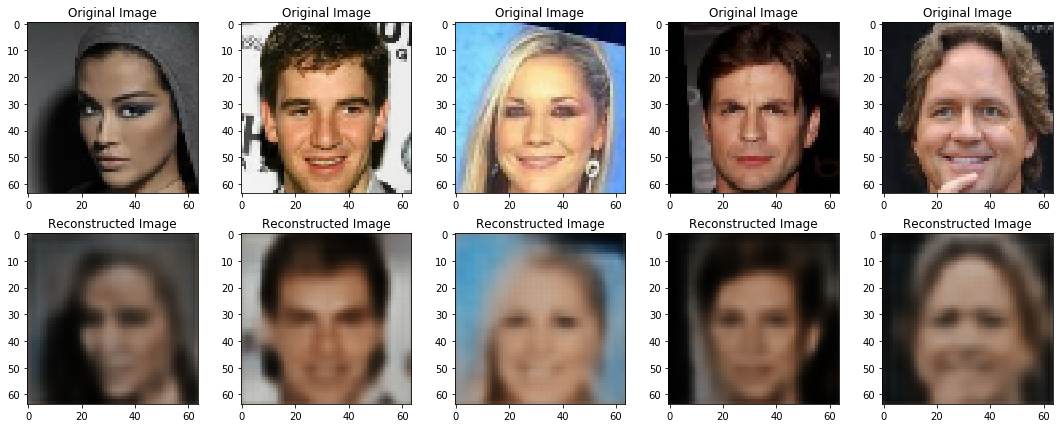

In [18]:
# 2.6
# your code here
fig, ax = plt.subplots(2, 5, figsize=(15,6))

for i, image_tuple in enumerate(val_ds.take(5)):
    image = image_tuple[0]
    image_pred = AE.predict(image)
    ax[0][i].imshow(image[0])
    ax[1][i].imshow(image_pred[0])
    ax[0][i].set_title(f'Original Image')
    ax[1][i].set_title(f'Reconstructed Image')
    
plt.tight_layout()

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

In [19]:
# 2.7 (PCA visualization)
# your code here
def get_hidden_output_PCA(model,X_val,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_val]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [102]:
def visualize_PCA(pca_result, y_val):
    color = ['b', 'g']
    male = y_val[:,0]
    smile = y_val[:,1]
    idx2male = {0: 'Female', 1: 'Male'}
    idx2smile = {0: 'Not smiling', 1: 'Smiling'}
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(16,8)
    
    for cat in range(2):
        indices = np.where(male==cat)
        ax[0].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2male[cat],s=15,color=color[cat],alpha=0.6)
        legend = ax[0].legend(markerscale=2, fontsize=14)
        legend.get_frame().set_facecolor('w') 
        ax[0].set_xlabel("first dimension", fontsize=18)
        ax[0].set_ylabel("second dimension", fontsize=18)

    for cat in range(2):
        indices = np.where(smile==cat)
        ax[1].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2smile[cat],s=15,color=color[cat],alpha=0.6)
        legend = ax[1].legend(markerscale=2, fontsize=14)
        legend.get_frame().set_facecolor('w') 
        ax[1].set_xlabel("first dimension", fontsize=18)
        ax[1].set_ylabel("second dimension", fontsize=18)


    fig.suptitle("visualization of hidden feature on reduced dimension by PCA", fontsize=24)
    
    plt.show()

In [86]:
X_val_1024 = []
y_val_1024 = []
for ((im, lab), im) in val_cond_ds.take(32):
    X_val_1024.append(im.numpy())
    y_val_1024.append(lab.numpy())
    
X_val_1024 = np.array(X_val_1024).reshape(-1, 64, 64, 3)
y_val_1024 = np.array(y_val_1024).reshape(-1, 2)

In [87]:
AE_pca_result = get_hidden_output_PCA(AE,X_val_1024,2,128)

Variance explained by PCA: 0.20875203609466553


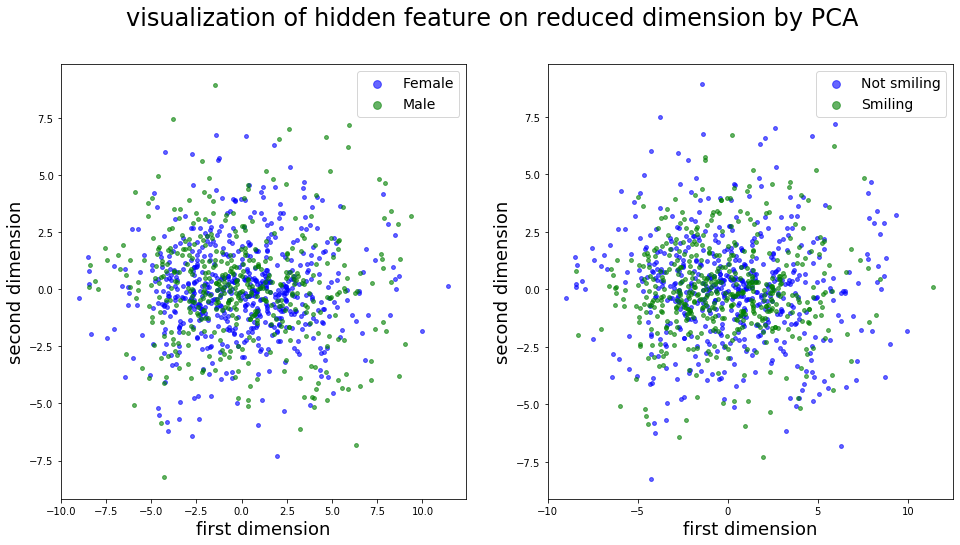

In [103]:
visualize_PCA(AE_pca_result, y_val_1024)

*Your answer here*<br>
Since the difference between attributes (smilling and male) are very subtle, the distribution of different classes learned by our vanilla AE is not so clear. We do not observe any clear clustering pattern from the PCs of the lattent space.

Compute also the t-SNE decomposition of the latent images. Does it uncover any characteristic structure? Please, explain your answer

In [118]:
# 2.7 (t-SNE visualization)
# your code here
def get_hidden_output_TSNE(model,X_val,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_val]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(hidden_feature)
    return tsne_result

In [119]:
def visualize_TSNE(tsne_result, y_val):
    color = ['b', 'g']
    male = y_val[:,0]
    smile = y_val[:,1]
    idx2male = {0: 'Female', 1: 'Male'}
    idx2smile = {0: 'Not smiling', 1: 'Smiling'}
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(16,8)
    
    for cat in range(2):
        indices = np.where(male==cat)
        ax[0].scatter(tsne_result[indices,0], tsne_result[indices, 1], label=idx2male[cat],s=15,color=color[cat],alpha=0.6)
        legend = ax[0].legend(markerscale=2, fontsize=14)
        legend.get_frame().set_facecolor('w') 
        ax[0].set_xlabel("first dimension", fontsize=18)
        ax[0].set_ylabel("second dimension", fontsize=18)

    for cat in range(2):
        indices = np.where(smile==cat)
        ax[1].scatter(tsne_result[indices,0], tsne_result[indices, 1], label=idx2smile[cat],s=15,color=color[cat],alpha=0.6)
        legend = ax[1].legend(markerscale=2, fontsize=14)
        legend.get_frame().set_facecolor('w') 
        ax[1].set_xlabel("first dimension", fontsize=18)
        ax[1].set_ylabel("second dimension", fontsize=18)


    fig.suptitle("visualization of hidden feature on reduced dimension by t-SNE", fontsize=24)
    
    plt.show()

In [120]:
AE_tsne_result = get_hidden_output_TSNE(AE,X_val_1024,2,128)

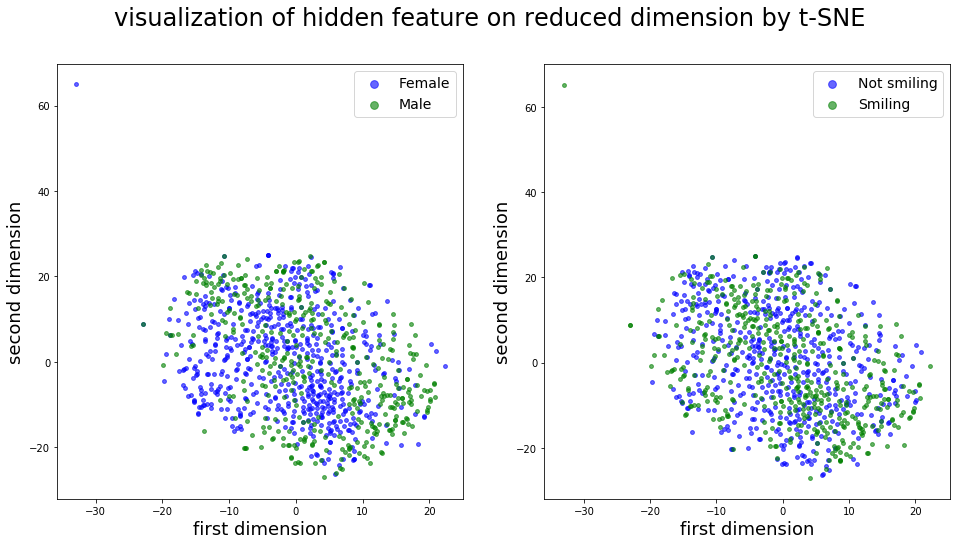

In [121]:
visualize_TSNE(AE_tsne_result, y_val_1024)

*Your answer here*<br>
It dose not uncover any characteristic structure. <br>
tSNE reduces the data dimension by converting similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. Since the original latent space is not well-clustered, the difference between classes is very subtle. Therefore, the vanilla AE failed to learn their distribution well.

---

<div class='exercise'> <b> Question 3: Set-up a Convolutional Variational Autoencoder [20 points].</b> </div>

In this exercise you will code a standard Variational Autoencoder. You will first create a custom layer `Sampling` that takes the mean and log-variance of a Gaussian distribution as inputs, and returns a sample from that distribution. You will use this sample as a latent representation of your probabilistic encoder conditioned on the input image, and use it to reconstruct an image. You will build the complete VAE architecture and study its properties.

You will need to minimize the negative ELBO function formed by a reconstruction loss and a regularization term over the mean and variance of the probabilistic encoder. You will train two VAE models, one with no regularization, and a second with regularization.

Follow these instructions:

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

**3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

## Answers

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

In [28]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        # your code here
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

In [159]:
# 3.2 
# your code here
input_shape = (64,64,3)

vae_inputs = layers.Input(shape=input_shape, name='vae_encoder_input')
x = ConvEncoder(input_shape=input_shape)(vae_inputs)
x = layers.Flatten()(x)
z_mean = layers.Dense(128, activation='linear', name='z_mean')(x)
z_log_var = layers.Dense(128, activation='linear', name='z_log_var')(x)
vae_latent_output = Sampling()((z_mean, z_log_var))

vae_decoder_input = layers.Input((128,), name="vae_decoder_input")
x = layers.Dense(1024, activation='relu')(vae_decoder_input)
x = layers.Reshape(target_shape=(4, 4, 64))(x)
vae_outputs = ConvDecoder(input_shape=(4, 4, 64))(x)

vae_encoder = models.Model(vae_inputs, vae_latent_output, name='vae_encoder')
display(vae_encoder.summary())

vae_decoder = models.Model(vae_decoder_input, vae_outputs, name='vae_decoder')
display(vae_decoder.summary())

Model: "vae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vae_encoder_input (InputLayer)  [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (ConvEncoder)           (None, 4, 4, 64)     70448       vae_encoder_input[0][0]          
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 1024)         0           encoder[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 128)          131200      flatten_9[0][0]                  
________________________________________________________________________________________

None

Model: "vae_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vae_decoder_input (InputLaye [(None, 128)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              132096    
_________________________________________________________________
reshape_12 (Reshape)         (None, 4, 4, 64)          0         
_________________________________________________________________
decoder (ConvDecoder)        (None, 64, 64, 3)         70387     
Total params: 202,483
Trainable params: 202,483
Non-trainable params: 0
_________________________________________________________________


None

In [160]:
output = vae_decoder(vae_encoder(vae_inputs))
VAE1 = models.Model(vae_inputs, output, name='vae1')

VAE2 = models.Model(vae_inputs, output, name='vae2')

VAE1.compile(optimizer='rmsprop', loss= 'mse')
display(VAE1.summary())

reg = 0.1
kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

VAE2.add_loss(kl_loss)
VAE2.compile(optimizer='rmsprop', loss= 'mse')
display(VAE2.summary())

Model: "vae1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vae_encoder_input (InputLaye [(None, 64, 64, 3)]       0         
_________________________________________________________________
vae_encoder (Model)          (None, 128)               332848    
_________________________________________________________________
vae_decoder (Model)          (None, 64, 64, 3)         202483    
Total params: 535,331
Trainable params: 535,331
Non-trainable params: 0
_________________________________________________________________


None

Model: "vae2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vae_encoder_input (InputLayer)  [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vae_encoder (Model)             (None, 128)          332848      vae_encoder_input[0][0]          
__________________________________________________________________________________________________
vae_decoder (Model)             (None, 64, 64, 3)    202483      vae_encoder[1][0]                
__________________________________________________________________________________________________
encoder (ConvEncoder)           (None, 4, 4, 64)     70448       vae_encoder_input[0][0]          
_______________________________________________________________________________________________

None

In [162]:
history_VAE1 = VAE1.fit(train_ds, epochs=3, validation_data=(val_ds))

Epoch 1/3
5086/5086 [==============================] - 206s 41ms/step - loss: 0.0680 - val_loss: 0.0000e+00
Epoch 2/3
5086/5086 [==============================] - 198s 39ms/step - loss: 0.0643 - val_loss: 0.0308
Epoch 3/3
5086/5086 [==============================] - 197s 39ms/step - loss: 0.0632 - val_loss: 0.0219


## Note
As we noticed that we set KL loss in VAE1. We modified the code and re-run the epoch in the last few minutes. Unfortunately, we don't have enough time to run 5 epochs.

In [37]:
history_VAE2 = VAE2.fit(train_ds, epochs=5, validation_data=(val_ds))

Epoch 1/5
5086/5086 [==============================] - 215s 42ms/step - loss: 0.0860 - val_loss: 0.0000e+00
Epoch 2/5
5086/5086 [==============================] - 203s 40ms/step - loss: 0.0828 - val_loss: 0.0452
Epoch 3/5
5086/5086 [==============================] - 204s 40ms/step - loss: 0.0824 - val_loss: 0.0421
Epoch 4/5
5086/5086 [==============================] - 204s 40ms/step - loss: 0.0822 - val_loss: 0.0433
Epoch 5/5
5086/5086 [==============================] - 205s 40ms/step - loss: 0.0821 - val_loss: 0.0487


In [163]:
VAE1.save_weights('weights_VAE1')

In [38]:
VAE2.save_weights('weights_VAE2')

In [165]:
def create_VAEs(reg):
    input_shape = (64,64,3)
    
    vae_inputs = layers.Input(shape=input_shape, name='vae_encoder_input')
    x = ConvEncoder(input_shape=input_shape)(vae_inputs)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(128, activation='linear', name='z_mean')(x)
    z_log_var = layers.Dense(128, activation='linear', name='z_log_var')(x)
    vae_latent_output = Sampling()((z_mean, z_log_var))
    
    vae_decoder_input = layers.Input((128,), name="vae_decoder_input")
    x = layers.Dense(1024, activation='relu')(vae_decoder_input)
    x = layers.Reshape(target_shape=(4, 4, 64))(x)
    vae_outputs = ConvDecoder(input_shape=(4, 4, 64))(x)
    
    vae_encoder = models.Model(vae_inputs, vae_latent_output, name='vae_encoder')
    vae_decoder = models.Model(vae_decoder_input, vae_outputs, name='vae_decoder')
    
    output = vae_decoder(vae_encoder(vae_inputs))
    VAE1 = models.Model(vae_inputs, output, name='vae1')
    
    VAE1.compile(optimizer='rmsprop', loss= 'mse')

    VAE2 = models.Model(vae_inputs, output, name='vae2')
    kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    VAE2.add_loss(kl_loss)
    VAE2.compile(optimizer='rmsprop', loss= 'mse')
    
    return VAE1, VAE2

VAE1, VAE2 = create_VAEs(reg=0.1)

In [166]:
VAE1.load_weights('weights_VAE1')

In [167]:
VAE2.load_weights('weights_VAE2')

**3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

*Your answer here*<br>
The reason is quite similar as the answer in Q 2.4. The outputs of these dense layers are used to create multivariate Gaussian distribution over the latent space. Although these stochastic process are expected to regularize the expression of latent space, we don't want to do it in an inefficient way. Thus, the mean and log variance should keep as much information from original images as possible. The linear activation function is appropriate as it does not lose any information from the previous layer. Instead, ReLU, sigmoid, or other non-linear activation functions reduce the amount of information and make the appropriate encoding difficult.

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

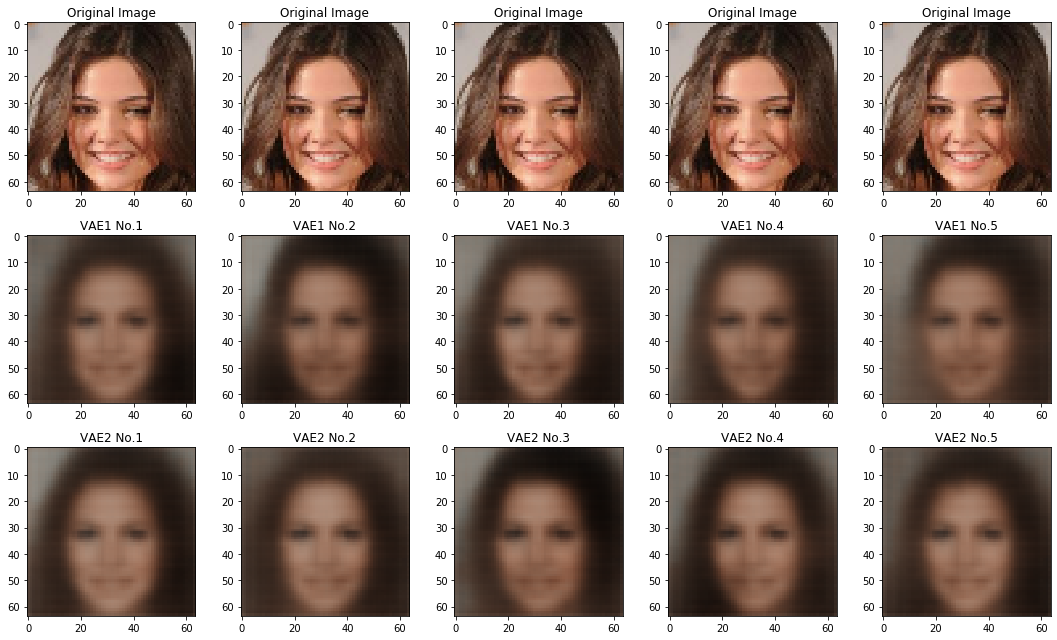

In [168]:
# 3.4
# your code here
fig, ax = plt.subplots(3, 5, figsize=(15,9))

for i, image_tuple in enumerate(val_ds.take(1)):
    image = image_tuple[0]
    
    for i in range(5):
        image_pred_1 = VAE1.predict(image)
        image_pred_2 = VAE2.predict(image)
        ax[0][i].imshow(image[0])
        ax[1][i].imshow(image_pred_1[0])
        ax[2][i].imshow(image_pred_2[0])
        ax[0][i].set_title(f'Original Image')
        ax[1][i].set_title(f'VAE1 No.{i+1}')
        ax[2][i].set_title(f'VAE2 No.{i+1}')
    
plt.tight_layout()

*your explanation here*<br>
The VAE1 shows relatively similar images while VAE2 shows some variations in the images. As we didn't include KL loss in VAE1, the backpropagation processes to optimize weights and reduce mse forced the variance to be small. In other words, sampling from a smaller variation distribution leads to closer ouputs of decoder compared to original images. Once we regularize the reconstruction using KL loss, the network is allowed to have some amount of variances in the latent multivariate Gaussian distribution. Thus, we see slightly different images in the outputs of VAE2.

**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

In [169]:
# 3.5
# your code here
VAE1_pca_result = get_hidden_output_PCA(VAE1,X_val_1024,1,128)
VAE2_pca_result = get_hidden_output_PCA(VAE2,X_val_1024,1,128)

Variance explained by PCA: 0.027421025559306145
Variance explained by PCA: 0.027302265167236328


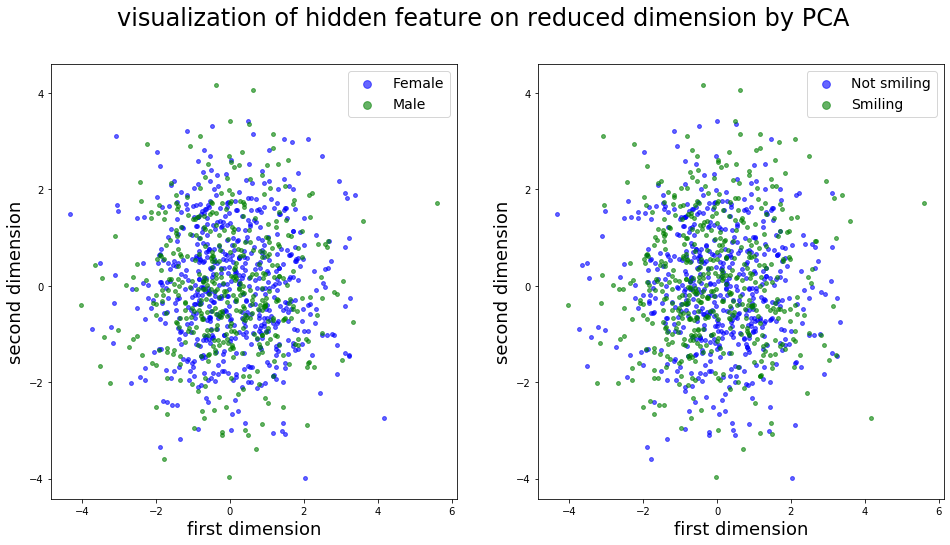

In [170]:
visualize_PCA(VAE1_pca_result, y_val_1024)

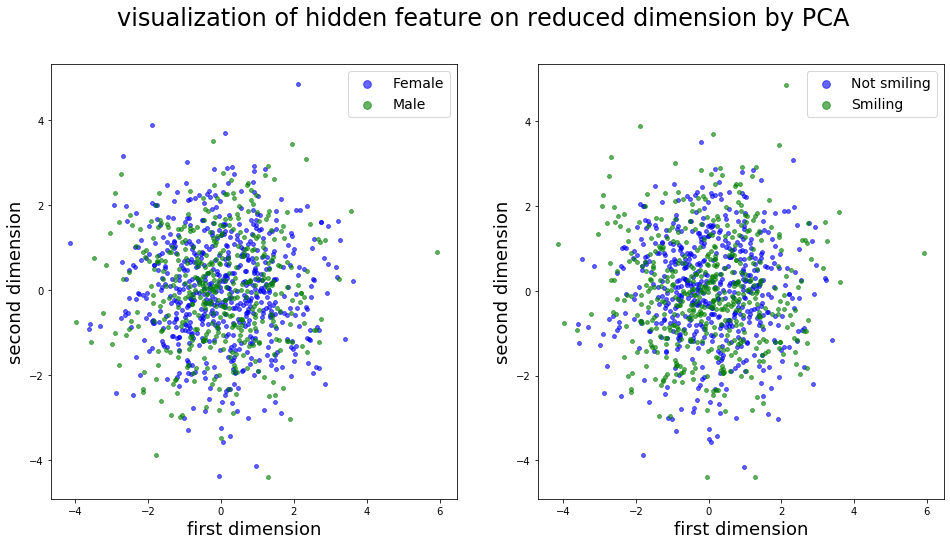

In [171]:
visualize_PCA(VAE2_pca_result, y_val_1024)

**Explanation of PCA visualization:** 

*your explanation here*<br>
We expect different class has different distribution in latent space as their distribution could be used to distinguish different classes of images. But again, as the differences between classes are not very strong, we could not observe a very strong clustering pattern in both latent spaces by PCA. However, the effect of regularization is clear in t-SNE plot (see below).

In [172]:
# 3.5
# your code here
VAE1_tsne_result = get_hidden_output_TSNE(VAE1,X_val_1024,1,128)
VAE2_tsne_result = get_hidden_output_TSNE(VAE2,X_val_1024,1,128)

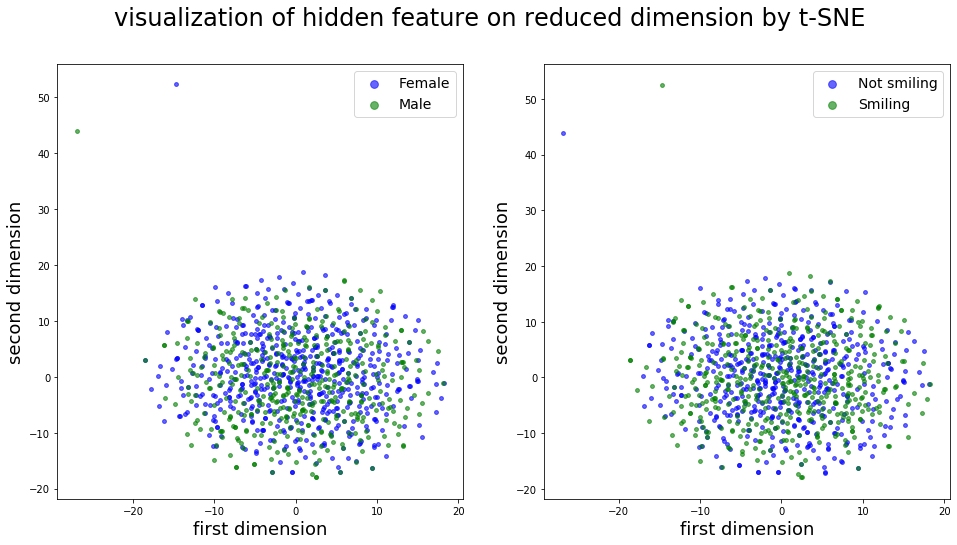

In [173]:
visualize_TSNE(VAE1_tsne_result, y_val_1024)

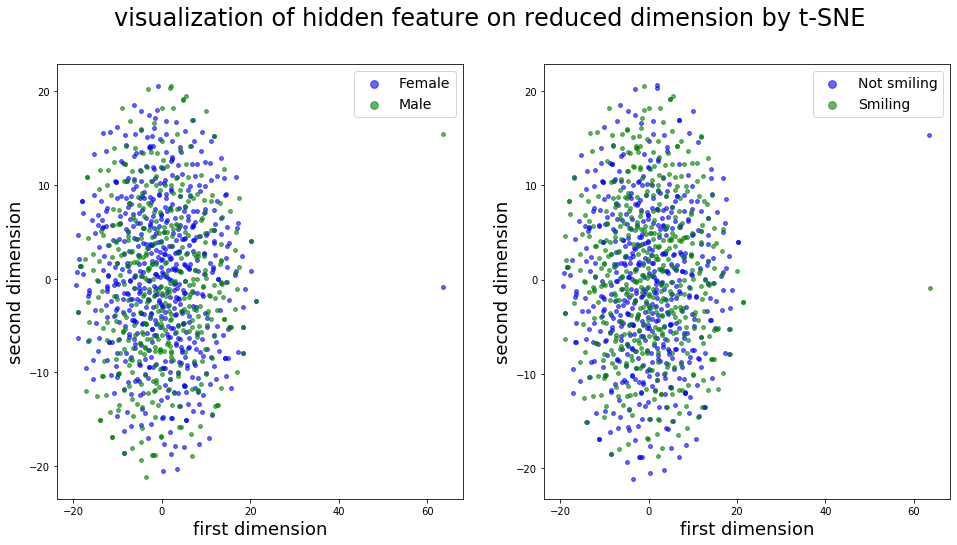

In [174]:
visualize_TSNE(VAE2_tsne_result, y_val_1024)

**Explanation of t-SNE decomposition:** 

*your explanation here*<br>
Again, as the differences between classes , after regularization, the pattern of t-SNE plots change from ellipse into circles, which is the effect of regularization. KL regularization forces the distribution of data in distribution into standard normal, which could be shown in the plots.

<div class='exercise'> <b> Question 4: Set-up a Conditional VAE. [20 points] </b> </div>

Conditional VAEs are similar to standard VAEs were you incorporate an input's label/information into the latent space. When the model is trained in this form, the model learns to distinguish between these features. For example, you can select features on latent space manually, and explore the space of representations in an explicit manner. We point you to [one](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/) and [two](https://ijdykeman.github.io/ml/2016/12/21/cvae.html) short tutorials on conditional VAEs. Additionally, you may be interested in reading the [original paper](http://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf), or a [continuation paper](https://papers.nips.cc/paper/7880-learning-latent-subspaces-in-variational-autoencoders.pdf). 

In this exercise you are going to build a conditional VAE, and reconstruct images by altering their attributes. For example, pick a set of 'not smiling men' and transform them by changing the label conditions such as 'smile' or 'gender' in latent space. You can choose whatever attributes you want, as long as the reconstructed latent space shows reasonable success when changing the attribute labels.

Follow this set of instructions:

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

**4.2** Train the model using the data generator you completed in Question 1.2 (use mean squared error loss and an optimizer of your choice). Print a summary of your model.

**We recommend saving your trained models**.

**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

For example, if your choice of attributes where 'Male' and 'Smiling', you should reconstruct these images with all possible attribute combinations.

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

## Answers

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

In [32]:
# 4.1
# your code here
input_shape = (64,64,3)

cvae_img_inputs = layers.Input(shape=input_shape, name='cvae_encoder_img_input')
x = ConvEncoder(input_shape=input_shape)(cvae_img_inputs)
cvae_img_outputs = layers.Flatten()(x)

cvae_attr_inputs = layers.Input(shape=(2,), name='cvae_encoder_attr_input')
cvae_latent_input = layers.concatenate([cvae_img_outputs, cvae_attr_inputs], axis = -1)

z_mean = layers.Dense(128, activation='linear', name='z_mean')(cvae_latent_input)
z_log_var = layers.Dense(128, activation='linear', name='z_log_var')(cvae_latent_input)
cvae_latent_output = Sampling()((z_mean, z_log_var))
                   
cvae_decoder_concatenate = layers.concatenate([cvae_latent_output, cvae_attr_inputs], axis = -1)
x = layers.Dense(1024, activation='relu')(cvae_decoder_concatenate)
x = layers.Reshape(target_shape=(4, 4, 64))(x)
cvae_outputs = ConvDecoder(input_shape=(4, 4, 64))(x)

CVAE = models.Model((cvae_img_inputs, cvae_attr_inputs), cvae_outputs, name='cvae')

reg4 = 0.1

kl_loss4 = - reg4 * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
CVAE.add_loss(kl_loss4)
CVAE.compile(optimizer='rmsprop', loss= 'mse')
CVAE.summary()

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cvae_encoder_img_input (InputLa [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (ConvEncoder)           (None, 4, 4, 64)     70448       cvae_encoder_img_input[0][0]     
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 1024)         0           encoder[0][0]                    
__________________________________________________________________________________________________
cvae_encoder_attr_input (InputL [(None, 2)]          0                                            
_______________________________________________________________________________________________

**4.2** Train the model using the generator you completed in Q1.3. Print a summary of your model.
**We recommend saving your trained models**.

In [72]:
# 4.2
# your code here
history_CVAE = CVAE.fit(train_cond_ds, epochs=5, validation_data=(val_cond_ds))
CVAE.summary()

Epoch 1/5
5086/5086 [==============================] - 213s 42ms/step - loss: 0.0872 - val_loss: 0.0000e+00
Epoch 2/5
5086/5086 [==============================] - 202s 40ms/step - loss: 0.0830 - val_loss: 0.0395
Epoch 3/5
5086/5086 [==============================] - 202s 40ms/step - loss: 0.0825 - val_loss: 0.0408
Epoch 4/5
5086/5086 [==============================] - 202s 40ms/step - loss: 0.0822 - val_loss: 0.0449
Epoch 5/5
5086/5086 [==============================] - 203s 40ms/step - loss: 0.0820 - val_loss: 0.0428
Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cvae_encoder_img_input (InputLa [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (ConvEncoder)           (None, 4, 4, 64)     70448       c

In [73]:
CVAE.save_weights('weights_CVAE')

In [33]:
def create_CVAE(reg):

    input_shape = (64,64,3)

    cvae_img_inputs = layers.Input(shape=input_shape, name='cvae_encoder_img_input')
    x = ConvEncoder(input_shape=input_shape)(cvae_img_inputs)
    cvae_img_outputs = layers.Flatten()(x)

    cvae_attr_inputs = layers.Input(shape=(2,), name='cvae_encoder_attr_input')
    cvae_latent_input = layers.concatenate([cvae_img_outputs, cvae_attr_inputs], axis = -1)

    z_mean = layers.Dense(128, activation='linear', name='z_mean')(cvae_latent_input)
    z_log_var = layers.Dense(128, activation='linear', name='z_log_var')(cvae_latent_input)
    cvae_latent_output = Sampling()((z_mean, z_log_var))

    cvae_decoder_concatenate = layers.concatenate([cvae_latent_output, cvae_attr_inputs], axis = -1)
    x = layers.Dense(1024, activation='relu')(cvae_decoder_concatenate)
    x = layers.Reshape(target_shape=(4, 4, 64))(x)
    cvae_outputs = ConvDecoder(input_shape=(4, 4, 64))(x)

    CVAE = models.Model((cvae_img_inputs, cvae_attr_inputs), cvae_outputs, name='cvae')

    reg = 0.1

    kl_loss4 = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    CVAE.add_loss(kl_loss4)
    CVAE.compile(optimizer='rmsprop', loss= 'mse')
    
    return CVAE

CVAE = create_CVAE(reg=0.1)
CVAE.load_weights('weights_CVAE')

**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

In [34]:
# 4.3
# Example case: select 5 images of men, not smiling; reconstruct with smiling and no smiling, and as smiling/no-smiling women.
# your code here
images_male_no_smiling = []

for ((images, attributes), _) in val_cond_ds.take(5):
    for i, attribute in enumerate(attributes):
        attribute_array = attribute.numpy()
        if attribute_array[1] == 0:
            attribute_array[1] += 1
        else:
            attribute_array[1] -= 1
        if np.all(attribute_array) == True:
            images_male_no_smiling.append(images[i])
        else:
            pass

In [35]:
first_5_images = np.array(images_male_no_smiling[0:5])

In [36]:
def get_attributes(male, smile):
    return np.array([[male, smile],
                    [male, smile],
                    [male, smile],
                    [male, smile],
                    [male, smile]], dtype='float32')

In [38]:
male_no_smile = get_attributes(1, 0)

In [41]:
for ((images, attributes), _) in val_cond_ds.take(1):
    print(images.shape)

(32, 64, 64, 3)


In [45]:
test = CVAE.predict((first_5_images, male_no_smile))

In [46]:
test.shape

(5, 64, 64, 3)

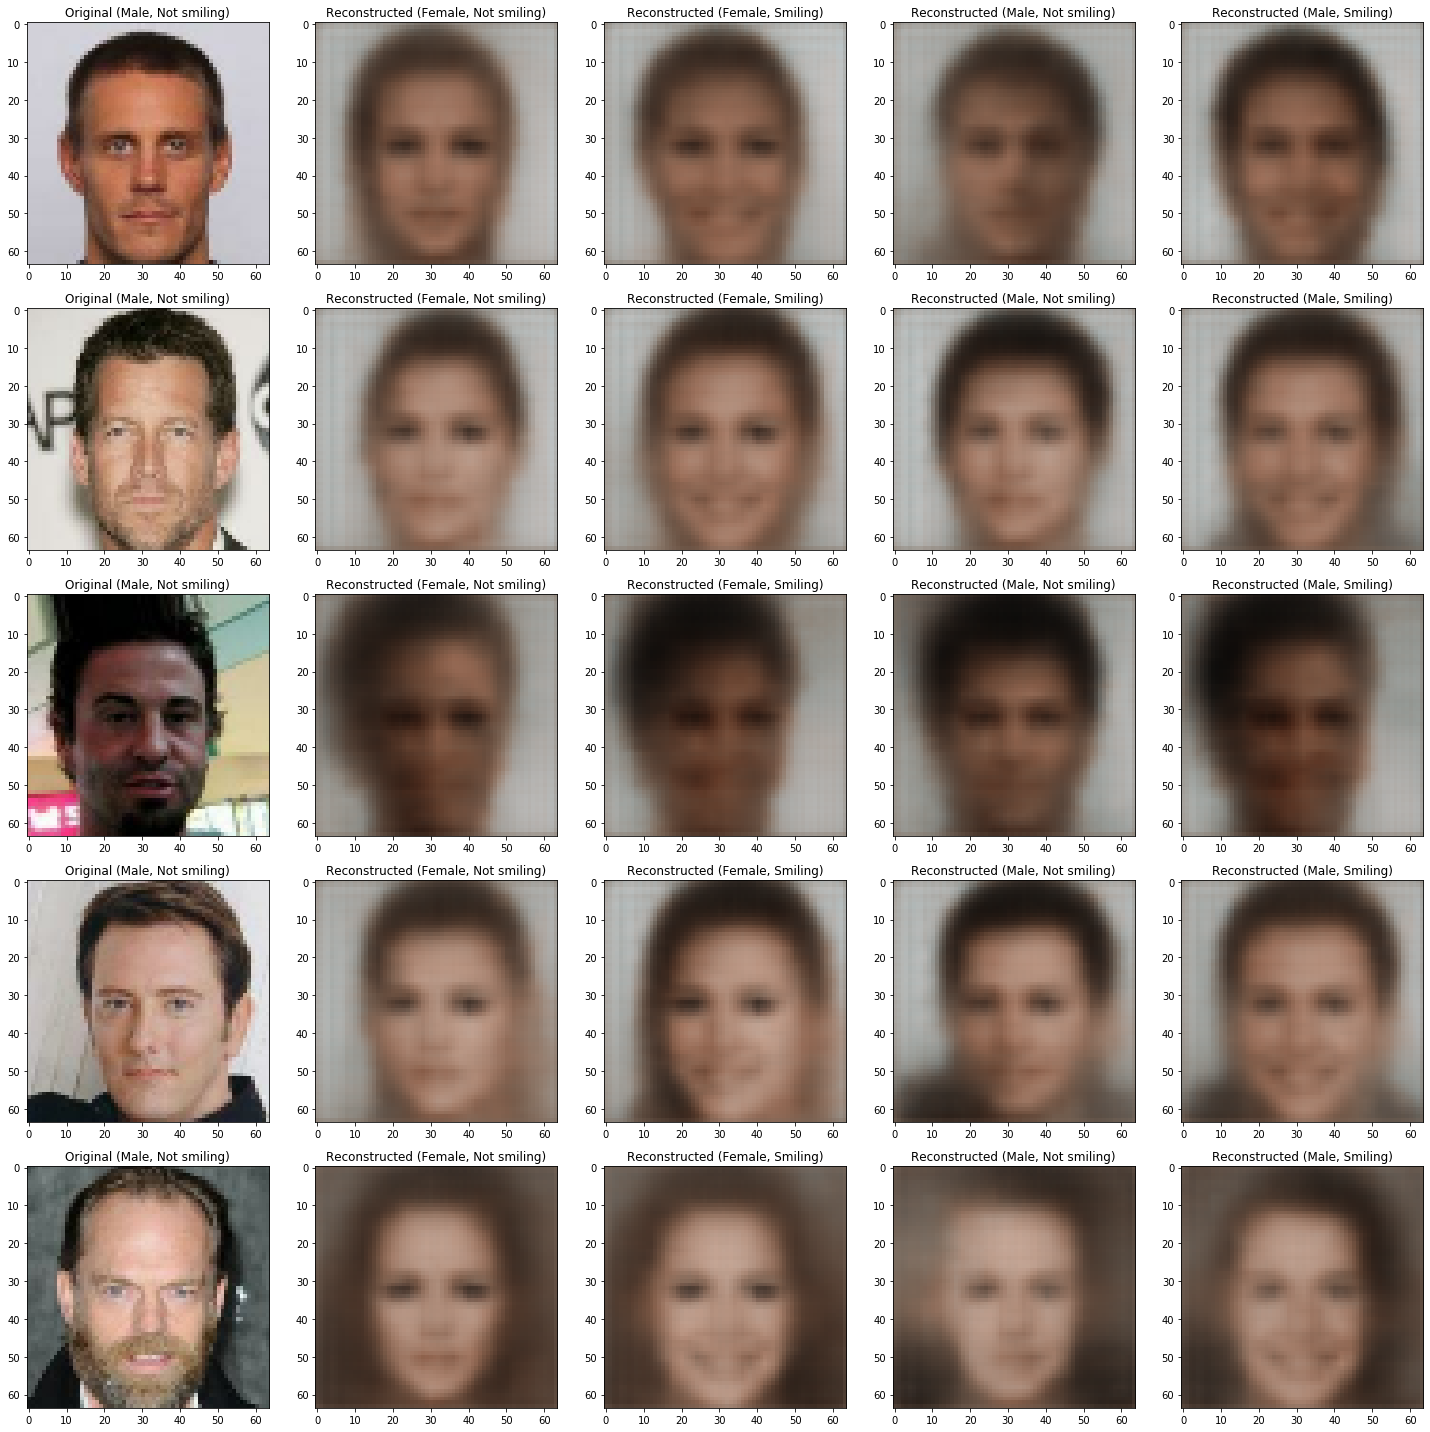

In [47]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

female_no_smile_pred = CVAE.predict((first_5_images, get_attributes(0, 0)))
female_smile_pred = CVAE.predict((first_5_images, get_attributes(0, 1)))
male_no_smile_pred = CVAE.predict((first_5_images, get_attributes(1, 0)))
male_smile_pred = CVAE.predict((first_5_images, get_attributes(1, 1)))

for i in range(5):
    ax[i,0].imshow(first_5_images[i])
    ax[i,0].set_title('Original (Male, Not smiling)')
    

    ax[i,1].imshow(female_no_smile_pred[i])
    ax[i,1].set_title('Reconstructed (Female, Not smiling)')

    ax[i,2].imshow(female_smile_pred[i])
    ax[i,2].set_title('Reconstructed (Female, Smiling)')
    
    ax[i,3].imshow(male_no_smile_pred[i])
    ax[i,3].set_title('Reconstructed (Male, Not smiling)')
    
    ax[i,4].imshow(male_smile_pred[i])
    ax[i,4].set_title('Reconstructed (Male, Smiling)')
    
plt.tight_layout()

*Your answer here*<br>
Although most pictures lose some expressions of the original image, we still see differences across the rows for all four columns. On the other hand, we can clearly find that images created using female attribute look like female and those created using smiling attribute look smiling. We believe our network learned the attributes very well.

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

In [80]:
CVAE.layers[3].input.shape, CVAE.layers[7].output.shape

(TensorShape([None, 2]), TensorShape([None, 128]))

In [78]:
# 4.4
# your code here
def get_CVAE_hidden_output_PCA(model,X_val,y_val,layer_index,out_dimension):
    output = tf.keras.backend.function(([model.layers[0].input], [model.layers[3].input]), [model.layers[layer_index].output])
    hidden_feature=np.array(output((X_val, y_val)))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [79]:
CVAE_pca_result = get_CVAE_hidden_output_PCA(CVAE, X_val_1024, y_val_1024, 7, 128)

Variance explained by PCA: 0.028789207339286804


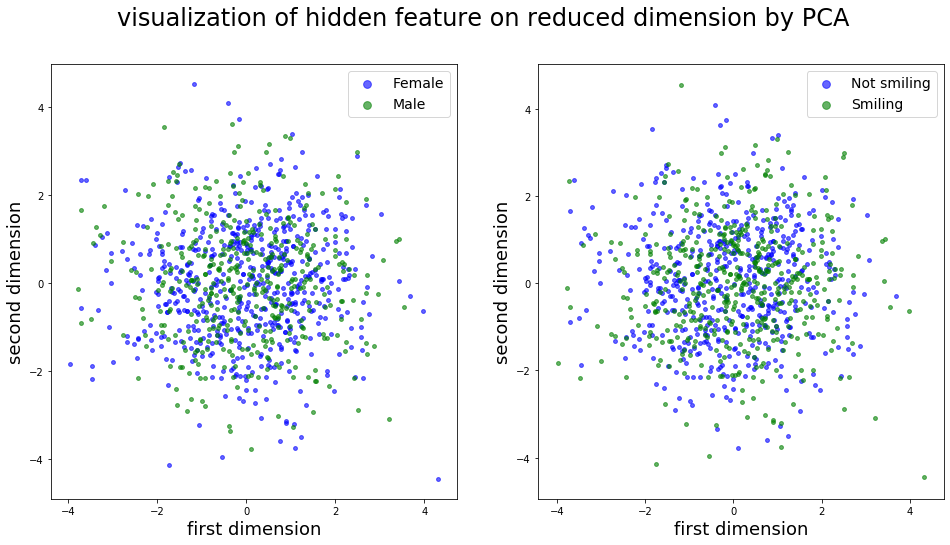

In [104]:
visualize_PCA(CVAE_pca_result, y_val_1024)

*Your answer here*<br>
As we can see form the plots, the distribution of two In CVAE, as the distribution is conditionded on the class, each class has its own distribution (independent to each other) in the latent space and they no longer need one universal distribution to represent different classes of images. The clustering pattern of different classes disappear. To generate an image of a particular number, just feed that number into the decoder along with a random point in the latent space sampled from a standard normal distribution. Even if the same point is fed in to produce two different images, the process will work correctly. Since the system no longer relies on the latent space to encode what class of images you are dealing with. Instead, the latent space encodes other information of the images.

In [112]:
# 4.4
# your code here
def get_CVAE_hidden_output_TSNE(model,X_val,y_val,layer_index,out_dimension):
    output = tf.keras.backend.function(([model.layers[0].input], [model.layers[3].input]), [model.layers[layer_index].output])
    hidden_feature=np.array(output((X_val, y_val)))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(hidden_feature)
    return tsne_result

In [114]:
CVAE_tsne_result = get_CVAE_hidden_output_TSNE(CVAE, X_val_1024, y_val_1024, 7, 128)

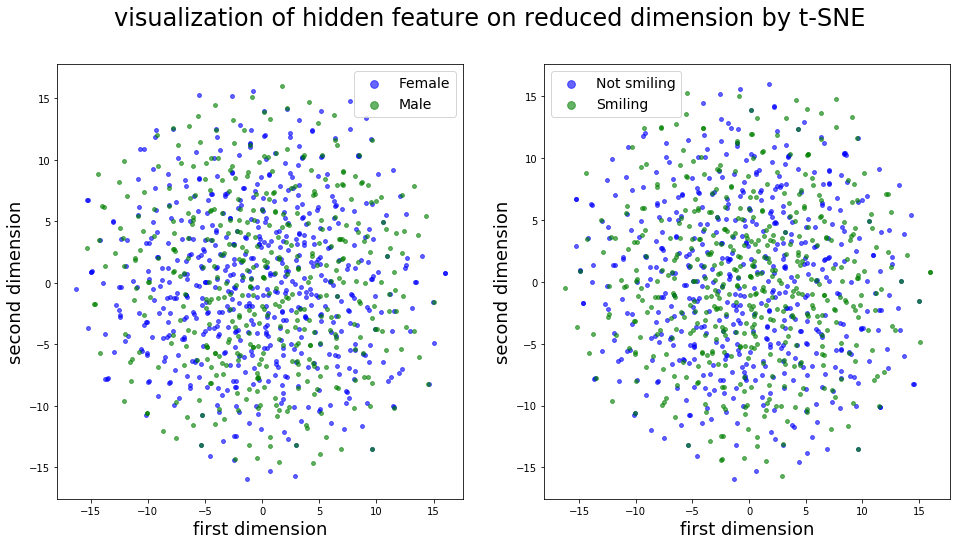

In [115]:
visualize_TSNE(CVAE_tsne_result, y_val_1024)

*Your answer here*<br>
As we can see from the t-SNE, the distribution of different classes become very similar and there is no clustering pattern in different classes. The reason is explained previously, the system no longer relies on the latent space to encode what class of images you are dealing with, therefore, different classes follows independent normal distribution in latent space.

---

<div class='exercise'> <b> Question 5: Generative Adversarial Networks. [20 points] </b> </div>

For the final exercise we are going to create a standard GAN composed of a generator, and a discriminator. GANs are tricky to train, so we encourage you to follow the given instructions when training your models. However, feel completely free to explore and present other layer architectures if they present better results.

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.

**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

**5.5** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.

## Answers

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

In [147]:
# 5.1
# your code here
noise_dim = 128
latent_dim = (8,8,128)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*64, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 64)))

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    adam = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    return model

g = make_generator_model()

In [148]:
g.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 4096)              524288    
_________________________________________________________________
batch_normalization_20 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 16, 16, 32)        51200     
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 32)      

In [151]:
noise = tf.random.normal([1, noise_dim])
generated_image = g(noise, training=False)

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

In [152]:
# 5.2
# your code here
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=input_shape))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

d = make_discriminator_model()
adam = tf.keras.optimizers.Adam(lr=0.0002)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
d.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 16)        784       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 32)        8224      
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 64)        

In [153]:
decision = d(generated_image)
print (decision)

tf.Tensor([[-0.00569279]], shape=(1, 1), dtype=float32)


**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.


In [154]:
# 5.3
# your code here
d.trainable = False
inputs = tf.keras.layers.Input(shape=(noise_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = tf.keras.Model(inputs, output)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)    
gan.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

In [155]:
# 5.4
# your code here
def show_images(imgs):
    n_imgs = imgs.shape[0]
    
    fig, ax = plt.subplots(1, n_imgs, figsize=(15, 20))
    plt.axis('off')
    for i in range(n_imgs):
        ax[i].imshow(np.clip(imgs[i].reshape(64,64,3), 0.0, 1.0))
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

Epoch: 0 	 Discr. Loss Real: [0.42069948, 0.0] 	 Discr. Loss Fake: [0.15009916, 1.0] 	 DCGAN Loss: [0.38864505, 0.71875]
Time:  841.7647590637207


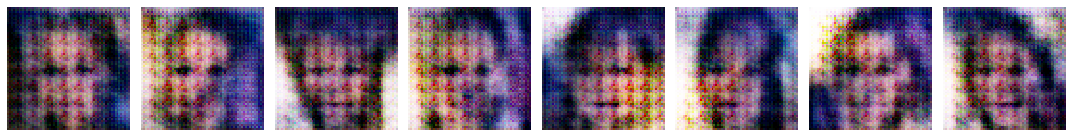

Epoch: 1 	 Discr. Loss Real: [0.7278546, 0.0] 	 Discr. Loss Fake: [0.16163474, 1.0] 	 DCGAN Loss: [0.1253837, 1.0]
Time:  841.3616962432861


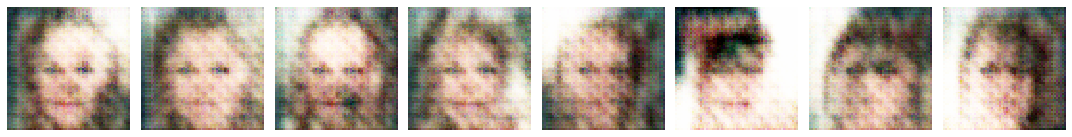

Epoch: 2 	 Discr. Loss Real: [0.55595136, 0.0] 	 Discr. Loss Fake: [0.43970364, 1.0] 	 DCGAN Loss: [0.7581876, 0.0625]
Time:  836.0999441146851


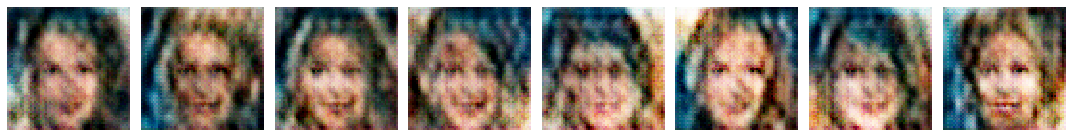

Epoch: 3 	 Discr. Loss Real: [0.5405128, 0.0] 	 Discr. Loss Fake: [0.25985327, 1.0] 	 DCGAN Loss: [1.0776117, 0.0625]
Time:  840.2841649055481


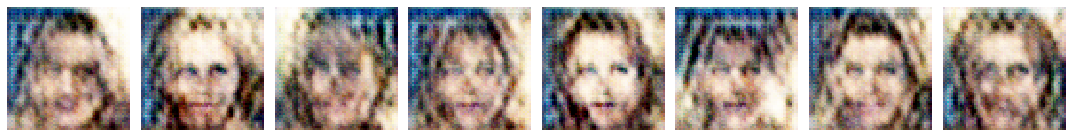

Epoch: 4 	 Discr. Loss Real: [0.5752989, 0.0] 	 Discr. Loss Fake: [0.2527557, 1.0] 	 DCGAN Loss: [2.2263544, 0.0]
Time:  839.3213930130005


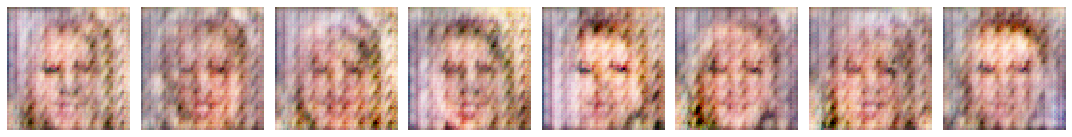

Epoch: 5 	 Discr. Loss Real: [0.67642796, 0.0] 	 Discr. Loss Fake: [0.02231476, 1.0] 	 DCGAN Loss: [1.4905138, 0.03125]
Time:  838.3153939247131


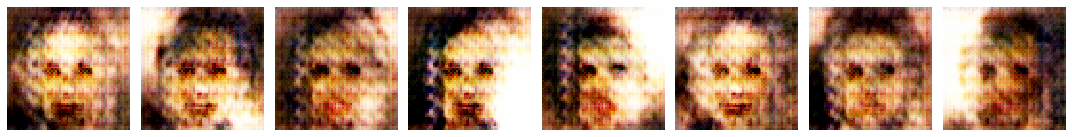

Epoch: 6 	 Discr. Loss Real: [0.62127817, 0.0] 	 Discr. Loss Fake: [0.11994227, 1.0] 	 DCGAN Loss: [1.088387, 0.0625]
Time:  836.1878235340118


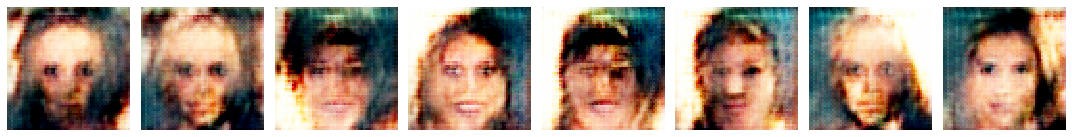

Epoch: 7 	 Discr. Loss Real: [0.4321548, 0.0] 	 Discr. Loss Fake: [0.034669697, 1.0] 	 DCGAN Loss: [0.9404235, 0.125]
Time:  842.3958940505981


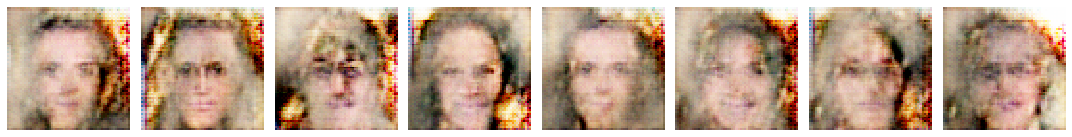

Epoch: 8 	 Discr. Loss Real: [0.42154992, 0.0] 	 Discr. Loss Fake: [0.13056988, 1.0] 	 DCGAN Loss: [2.9133382, 0.0]
Time:  841.91557097435


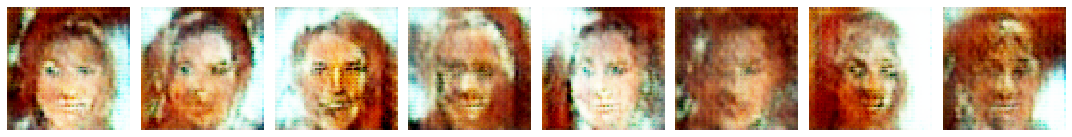

Epoch: 9 	 Discr. Loss Real: [0.59547204, 0.0] 	 Discr. Loss Fake: [0.49226323, 0.96875] 	 DCGAN Loss: [1.4059231, 0.03125]
Time:  831.9720122814178


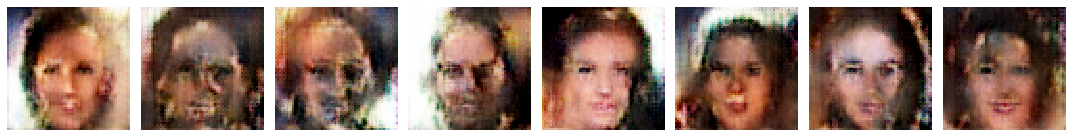

In [158]:
BATCH_SIZE = 32
epochs = 10

losses = {"D":[], "G":[]}

y_smoother = 0.1
y_real = tf.ones((BATCH_SIZE,1))
y_fake = tf.zeros((BATCH_SIZE,1))


for epoch in range(epochs):
    
    start = time.time()
    
    i = 0
    for x_real in train_dataset:
        noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim))
        x_fake = g.predict_on_batch(noise)
        
        # train discriminator
        d_loss_real = d.train_on_batch(x_real, y_real - y_smoother)
        
        d_loss_fake = d.train_on_batch(x_fake, y_fake)
        
        # train generator
        noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim))
        dcgan_loss = gan.train_on_batch(noise, y_real)
        
    # Only store losses from final
    losses["D"].append((d_loss_real[0]+d_loss_fake[0])/2.)
    losses["G"].append(dcgan_loss[0])    
        
    print(f'Epoch: {epoch} \t Discr. Loss Real: {d_loss_real} \t Discr. Loss Fake: {d_loss_fake} \t DCGAN Loss: {dcgan_loss}')
    print("Time: ", time.time()-start) 
    
    show_images(x_fake[:8])

We see images look like human face but not as good as VAE. VAE takes substantial information from the original input images to set means and variances in the latent space. Then it samples from multivariate Gaussian distribution and generates the output images. Therefore, it keeps great amount of information from the original images. On the other hand, GAN does not rely on the input images. It first generate random numbers and pass them to the trained network, and obtain final decoder outputs. Therefore, GAN is much more difficult to make appropriate images compared to VAE.

**5.5** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.



*your answer here*<br>
Yes we can. By using KL loss and empirical distribution, we are just trying to creat a naive disctrimanator to learn z_mu and z_log_var. The gaming between discriminator and generator could be kept as the new dsicriminator is trying to learn the true z_mu and z_log_var and the generator is still trying to fool it. It still keeps the structure of GAN, but the discriminator may not perform so well as it is not sophisticated.

---